In [1]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('./data/movieData.csv', parse_dates=['Thursday'])
df['dayofyear'] = df.groupby('name')['Thursday'].transform(lambda x: x.dt.dayofyear)
df['name'] = df['name'].str.lower()
df.head()

,Rank,WeeklyGross,PctChangeWkGross,Theaters,DeltaTheaters,AvgRev,GrossToDate,Week,Thursday,name,year,Winner,dayofyear
0,17.0,967378,NaN,14.0,NaN,69098.0,967378,1,1990-11-18,dances with wolves,1990,True,322
1,9.0,3871641,300.0,14.0,NaN,276546.0,4839019,2,1990-11-25,dances with wolves,1990,True,329
2,3.0,12547813,224.0,1048.0,1034.0,11973.0,17386832,3,1990-12-02,dances with wolves,1990,True,336
3,4.0,9246632,-26.3,1053.0,5.0,8781.0,26633464,4,1990-12-09,dances with wolves,1990,True,343
4,4.0,7272350,-21.4,1051.0,-2.0,6919.0,33905814,5,1990-12-16,dances with wolves,1990,True,350


## Look at it all

I want to cheat it so we don't have this carry over when something is released in Dec

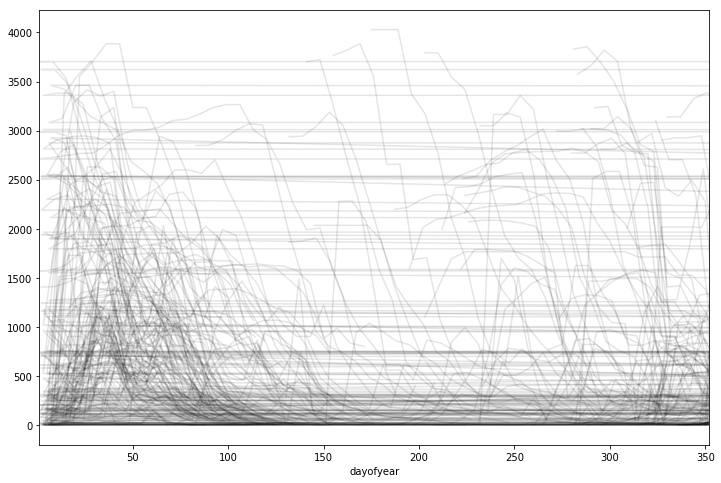

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = df.groupby('name').plot(x='dayofyear', y='Theaters', ax=ax, color='k', alpha=.1)
ax.legend().set_visible(False)

This is more like it

In [ ]:
yrs = df['Thursday'].dt.year
fig, ax = plt.subplots(figsize=(12, 8))


ax.axvline(72, c='r', alpha=.5)
_ = df.groupby(['name', yrs]).plot(x='dayofyear', y='Theaters', ax=ax, color='k', alpha=.2)
ax.legend().set_visible(False)
ax.annotate("'Avg Date' of Academy Awards", (72, 3900))
ax.set_title('Number of Theaters Showing Best Picture Nominees (Since 1990, By Day of Year)', size=16)

## Pemieres

In [ ]:
premieres = df.groupby('name').first().reset_index()
premieres.head()

If you had the sneaking suspicion that more movies were releasing closer to the end of the year, you were right.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(premieres['Thursday'].dt.dayofyear)
ax.set_title('Best Picture Nominee Premiere by Day of Year', size=20)

That trend has only gotten worse as time goes on.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in premieres.groupby('Winner'):
    ax.scatter(group['Thursday'].dt.dayofyear, group['year'], label=name)
    _ = [ax.axhline(i, color='k', alpha=.1) for i in range(1990, 2017)]
    ax.set_title('Best Picture Nominee Release Day of Year (By Year)', size=20)

ax.legend(fontsize=12).set_title('Best Picture', prop={'size':16})

In fact, if we partition each year into 4 buckets:

    [0, 100), [100, 200), [200, 300), [300, 365]

In [ ]:
fn = lambda x: pd.cut(x, bins=[0, 100, 200, 300, 365], labels=['1st', '2nd', '3rd', '4th'])
premieres['releaseQuarter'] = premieres.groupby('year')['dayofyear'].apply(fn)

releasePctByQuarter = premieres.groupby('year')['releaseQuarter'].value_counts().unstack().fillna(0)

We see that the number of movies releasing in the last stretch of the year has gone up over time

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

x = releasePctByQuarter.index
y1, y2, y3, y4 = [releasePctByQuarter[x].values for x in releasePctByQuarter]
ax.bar(x, y1)
ax.bar(x, y2, bottom=y1)
ax.bar(x, y3, bottom=y2+y1)
ax.bar(x, y4, bottom=y3+y2+y1)
plt.legend(releasePctByQuarter.columns)

ax.set_title('Premiere Release by Quarter', size=20)

### Release vs Award Data

To figure out what the Academy's got to do with it, we'll use the dataset from last time

In [ ]:
academy = pd.read_csv('./data/oscarsDates.csv', parse_dates=['announcement', 'show'])
academy.head()

Let's look at the relationship between the award shows and premiere data

In [ ]:
allIn_pre = premieres.merge(academy)

allIn_pre['days_before_announcement'] = (allIn_pre['announcement'] - allIn_pre['Thursday']).dt.days
allIn_pre['days_before_show'] = (allIn_pre['show'] - allIn_pre['Thursday']).dt.days

Is there trending in the difference between release date and award show?

In [ ]:
X = allIn_pre['year']
y = allIn_pre['days_before_announcement']
a, b = np.polyfit(X, y, 1)
yfit = [b + a * xi for xi in X]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y)
ax.plot(X, yfit, color='gray')

Removing some of the noise through averages tells a slightly-more-compelling story.

In [ ]:
y = allIn_pre.groupby('year')['days_before_announcement'].mean()
X = y.index
a, b = np.polyfit(X, y, 1)
yfit = [b + a * xi for xi in X]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y)
ax.plot(X, yfit, 'gray')
ax.set_title('Average Days Between Release and Announcement', size=20)

Looking at correlations, not much here besides

- inverse relationship between opening rank and nielsen numbers

In [ ]:
allIn_pre.corr()

In [ ]:
plt.scatter(allIn_pre['Rank'], allIn_pre['nielsen'])

### What about the last week for each movie

In [ ]:
closings = df.groupby('name').last().reset_index()
closings.head()

In [ ]:
allIn_post = closings.merge(academy)

allIn_post['days_after_show'] = (allIn_post['Thursday'] - allIn_post['show']).dt.days

Here we see:

- Movies that win have a longer tail
- Nielsen ratings correlated with and Theaters
- Weakly Correlated with Avg Rev and Gross to Date

In [ ]:
allIn_post.corr()

It's more telling to actually look at movies that stuck around after the show

In [ ]:
actual_post = allIn_post[allIn_post['days_after_show'] > 0]

In [ ]:
actual_post.corr()

In [ ]:
readable = lambda x: '{:,.2f}'.format(x)
actual_post.groupby('Winner')['Week', 'GrossToDate'].describe().T.applymap(readable)

## Effect of announcement on theaters

In [ ]:
def plot_year_releases(df, year):
    fig, ax = plt.subplots(figsize=(16, 8))
    for name, group in df[df['year'] == year].groupby('name'):
        group.plot(x='Thursday', y='Theaters', ax=ax, label=name)
        announcement, show = academy[academy['year'] == year][['announcement', 'show']].values[0]
        plt.axvline(pd.Timestamp(announcement), c='k', alpha=.5)
        plt.axvline(pd.Timestamp(show), c='k', alpha=.5)
    return ax

Starts off pretty boring

In [ ]:
plot_year_releases(df, 1990)

Curiously, Silence of the Lambs was way before everything else

In [ ]:
plot_year_releases(df, 1991)

The Crying Game

In [ ]:
plot_year_releases(df, 1992)

93-96 were boring

In [ ]:
plot_year_releases(df, 1997)

Titanic won, and that was huge

In [ ]:
plot_year_releases(df, 1997)

American Beauty drops off hard, and then the announcement

In [ ]:
plot_year_releases(df, 1999)

Oscar Buzz started happening.

In [ ]:
plot_year_releases(df, 2000)

In [ ]:
plot_year_releases(df, 2002)

In [ ]:
plot_year_releases(df, 2004)

In [ ]:
plot_year_releases(df, 2005)

In [ ]:
plot_year_releases(df, 2006)

In [ ]:
plot_year_releases(df, 2007)

In [ ]:
plot_year_releases(df, 2008)

In [ ]:
plot_year_releases(df, 2009)

In [ ]:
plot_year_releases(df, 2010)

In [ ]:
plot_year_releases(df, 2011)

In [ ]:
plot_year_releases(df, 2012)

In [ ]:
plot_year_releases(df, 2013)

In [ ]:
plot_year_releases(df, 2014)

In [ ]:
plot_year_releases(df, 2015)

In [ ]:
plot_year_releases(df, 2016)